# mcdc_analysis_d22a

### Purpose
Using Monte Carlo Drift Correction (MCDC), analyse data produced by [data_d22a.ipynb](https://github.com/grandey/d22a-mcdc/blob/main/data_d22a.ipynb), including production of figures and tables.

### Input data requirements
NetCDF files in [data/](https://github.com/grandey/d22a-mcdc/tree/main/data/) (produced by [data_d22a.ipynb](https://github.com/grandey/d22a-mcdc/blob/main/data_d22a.ipynb)), each containing a global mean time series for a given variable, AOGCM variant, and CMIP6 experiment.

### Output files written
Figures (TODO) and tables (TODO).

### History
BSG, 2022.

In [1]:
! date

Fri Aug 19 10:59:33 +08 2022


In [2]:
from functools import cache
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from scipy import stats
import statsmodels.api as sm
import xarray as xr

In [3]:
# Matplotlib settings
%matplotlib inline
plt.rcParams['savefig.dpi'] = 300

In [4]:
# Package versions
for p in [xr, np, pd, sm, xr]:
    print(f'{p.__name__}: {p.__version__}')

xarray: 2022.6.0
numpy: 1.23.1
pandas: 1.4.3
statsmodels.api: 0.13.2
xarray: 2022.6.0


In [5]:
# Random number generator
rng = np.random.default_rng(12345)
rng

Generator(PCG64) at 0x16BB9F220

## Identify AOGCM variants (source-member pairs)
Note: the AOGCM variants identified should match those identified by data_d22a.ipynb.

In [6]:
# Location of data produced by data_d22a.ipynb
in_base = pathlib.Path.cwd() / 'data' / 'regrid_missto0_yearmean_fldmean_mergetime'

# Core variables required
core_var_list = ['rsdt', 'rsut', 'rlut', # R = rsdt-rsut-rlut
                 'hfds',  # H (without flux correction)
                 'zostoga']  # Z

# Experiments required (with corresponding names, used for figs later)
exp_dict = {'piControl': 'Control', 'historical': 'Historical',
            'ssp126': 'SSP1-2.6', 'ssp245': 'SSP2-4.5',
            'ssp370': 'SSP3-7.0', 'ssp585': 'SSP5-8.5'}

# Identify source-member pairs to use
source_member_list = sorted([d.name for d in in_base.glob(f'rsdt/[!.]*_*')])  # this list will be reduced
for source_member in source_member_list.copy():  # loop over copy of source-member pairs to check data availability
    for var in core_var_list:  # loop over required variables
        for exp in exp_dict.keys():  # loop over experiments
            #in_fns = sorted(in_base.glob(f'{var}/{source_member}/{var}_{source_member}_{exp}.mergetime.nc'))
            in_fn = in_base.joinpath(f'{var}/{source_member}/{var}_{source_member}_{exp}.mergetime.nc')
            if not in_fn.is_file():  # if input file for this experiment does not exist...
                try:
                    source_member_list.remove(source_member)  # ... do not use this source-member pair
                except ValueError:  # when source-member pair has previously been removed
                    pass

print(f'{len(source_member_list)} source-member pairs identified.')
source_member_list

20 source-member pairs identified.


['ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r1i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CMCC-ESM2_r1i1p1f1',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-ESM2-1_r1i1p1f2',
 'CanESM5_r1i1p1f1',
 'EC-Earth3-Veg-LR_r1i1p1f1',
 'EC-Earth3-Veg_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'GISS-E2-1-G_r1i1p5f1',
 'GISS-E2-1-H_r1i1p1f2',
 'IPSL-CM6A-LR_r1i1p1f1',
 'MIROC6_r1i1p1f1',
 'MPI-ESM1-2-HR_r1i1p1f1',
 'MPI-ESM1-2-LR_r1i1p1f1',
 'MRI-ESM2-0_r1i1p1f1',
 'NorESM2-LM_r1i1p1f1',
 'NorESM2-MM_r1i1p1f1',
 'UKESM1-0-LL_r1i1p1f2']

## Read input data

In [7]:
%%time
# Dictionary to hold input DataArrays
in_da_dict = {}  # keys will be tuples of (source_member, exp, var)

# List of input data variables 
in_var_list = ['rsdt', 'rsut', 'rlut',  # R = rsdt-rsut-rlut
               'hfds',  # H (without flux correction)
               'hfcorr',  # flux correction, available for very few source-member pairs
               'zostoga']  # Z

# Loop over source-member pairs, experiments, and variables
for source_member in source_member_list:
    for exp in exp_dict.keys():
        for var in in_var_list:
            # Read input data (if they exist)
            in_fn = in_base.joinpath(f'{var}/{source_member}/{var}_{source_member}_{exp}.mergetime.nc')
            try:
                in_ds = xr.open_dataset(in_fn)  # Dataset
                in_da = in_ds[var]  # DataArray
                # Remove degenerate lon and lat dimensions
                in_da = in_da.squeeze()
                # Convert time units to year
                in_da['time'] = (in_da['time'] // 1e4).astype(int)
                in_da['time'].attrs['units'] = 'yr'
                # Convert zostoga units to mm
                if var == 'zostoga':
                    in_da.data = in_da.data * 1e3
                    in_da.attrs['units'] = 'mm'
                # Check: do data have non-zero values?
                if (in_da**2).sum() == 0:
                    print(f'Skipping {source_member} {exp} {var} (no non-zero values)')
                else:
                    # Save to dictionary
                    in_da_dict[(source_member, exp, var)] = in_da
            except FileNotFoundError:
                pass

print(f'in_da_dict contains {len(in_da_dict)} DataArrays')

in_da_dict contains 606 DataArrays
CPU times: user 1.52 s, sys: 52.3 ms, total: 1.57 s
Wall time: 1.69 s


## Basic processing of input data

In [8]:
# Are there any gaps (missing years) in the data coverage?
for source_member in source_member_list:
    for exp in exp_dict.keys():
        for var in in_var_list:
            try:
                in_da = in_da_dict[(source_member, exp, var)]
                # Is the interval betweeen successive time coords always 1 year?
                intervals = in_da.time.data[1:] - in_da.time.data[:-1]
                if not np.all(intervals == 1):
                    # If a gap is found, limit to period before gap
                    gap_i = int(np.where(intervals != 1)[0])  # identify first gap
                    gap_yr = in_da.time.data[gap_i]  # final year before gap
                    len_old = len(in_da)  # old length
                    in_da = in_da.where(in_da.time <= gap_yr, drop=True)  # limit data
                    in_da_dict[(source_member, exp, var)] = in_da  # update dict
                    len_new = len(in_da)  # new length
                    print(f'{source_member} {exp} {var} had missing years; using period before gap; '
                          f'length {len_old} -> {len_new}.')
            except KeyError:
                pass

IPSL-CM6A-LR_r1i1p1f1 piControl hfds had missing years; using period before gap; length 1800 -> 1000.


In [9]:
# For a given source-member and experiment, is the time coverage consistent between core variables?
for source_member in source_member_list:
    for exp in exp_dict.keys():
        try:
            # Time coords for primary variables of interest
            time1 = in_da_dict[(source_member, exp, 'rsdt')].time.data
            time2 = in_da_dict[(source_member, exp, 'rsut')].time.data
            time3 = in_da_dict[(source_member, exp, 'rlut')].time.data
            time4 = in_da_dict[(source_member, exp, 'hfds')].time.data
            time5 = in_da_dict[(source_member, exp, 'zostoga')].time.data
            # Are the time coords the same?
            if not (np.array_equal(time1, time2) and np.array_equal(time1, time3) and
                    np.array_equal(time1, time4) and np.array_equal(time1, time5)):
                print(f'{source_member} {exp} has inconsistent time coord')
                # Are the start years the same?
                start_list = [t[0] for t in [time1, time2, time3, time4, time5]]
                if len(set(start_list)) > 1:
                    print(f'  Start years differ: {start_list}')
                start_max = max(start_list)  # earliest year available for all
                # Are the end years the same?
                end_list = [t[-1] for t in [time1, time2, time3, time4, time5]]
                if len(set(end_list)) > 1:
                    print(f'  End years differ: {end_list}')
                end_min = min(end_list)  # latest year availabe for all
                # Limit to shared period
                print(f'  Limiting to shared period of {start_max}-{end_min} ({end_min-start_max+1} years)')
                for var in in_var_list:  # limit time coord for all variables (including hfcorr)
                    try:
                        in_da = in_da_dict[(source_member, exp, var)]
                        in_da = in_da.where((in_da.time >= start_max) & (in_da.time <= end_min), drop=True)
                        in_da_dict[(source_member, exp, var)] = in_da
                    except KeyError:
                        pass
        except KeyError:
            pass

CanESM5_r1i1p1f1 ssp585 has inconsistent time coord
  End years differ: [2300, 2300, 2300, 2300, 2180]
  Limiting to shared period of 1850-2180 (331 years)
EC-Earth3-Veg_r1i1p1f1 piControl has inconsistent time coord
  End years differ: [3849, 3849, 3849, 2349, 2349]
  Limiting to shared period of 1850-2349 (500 years)
IPSL-CM6A-LR_r1i1p1f1 piControl has inconsistent time coord
  End years differ: [3849, 3849, 3849, 2849, 3849]
  Limiting to shared period of 1850-2849 (1000 years)
MIROC6_r1i1p1f1 piControl has inconsistent time coord
  End years differ: [3999, 3999, 3999, 3699, 3999]
  Limiting to shared period of 3200-3699 (500 years)
UKESM1-0-LL_r1i1p1f2 piControl has inconsistent time coord
  End years differ: [3839, 3839, 3839, 3839, 3059]
  Limiting to shared period of 1960-3059 (1100 years)


In [10]:
# Shift PI control start year to 1 (arbitrary)
for source_member in source_member_list:
    for var in in_var_list:
        try:
            in_da = in_da_dict[(source_member, 'piControl', var)]
            in_da['time'] = in_da['time'] - in_da['time'][0] + 1  # shift
        except IndexError:
            print('IndexError encountered:', source_member, var, in_da)
        except KeyError:
            pass

In [11]:
# How much PI control data are available for each source-member pair?
for source_member in source_member_list:
    in_da = in_da_dict[(source_member, 'piControl', 'zostoga')]
    print(f'{source_member} piControl has {len(in_da)} years')

ACCESS-CM2_r1i1p1f1 piControl has 500 years
ACCESS-ESM1-5_r1i1p1f1 piControl has 1000 years
CMCC-CM2-SR5_r1i1p1f1 piControl has 500 years
CMCC-ESM2_r1i1p1f1 piControl has 500 years
CNRM-CM6-1_r1i1p1f2 piControl has 500 years
CNRM-ESM2-1_r1i1p1f2 piControl has 500 years
CanESM5_r1i1p1f1 piControl has 1000 years
EC-Earth3-Veg-LR_r1i1p1f1 piControl has 501 years
EC-Earth3-Veg_r1i1p1f1 piControl has 500 years
EC-Earth3_r1i1p1f1 piControl has 501 years
GISS-E2-1-G_r1i1p5f1 piControl has 201 years
GISS-E2-1-H_r1i1p1f2 piControl has 451 years
IPSL-CM6A-LR_r1i1p1f1 piControl has 1000 years
MIROC6_r1i1p1f1 piControl has 500 years
MPI-ESM1-2-HR_r1i1p1f1 piControl has 500 years
MPI-ESM1-2-LR_r1i1p1f1 piControl has 1000 years
MRI-ESM2-0_r1i1p1f1 piControl has 701 years
NorESM2-LM_r1i1p1f1 piControl has 501 years
NorESM2-MM_r1i1p1f1 piControl has 500 years
UKESM1-0-LL_r1i1p1f2 piControl has 1100 years


In [12]:
# Limit SSPs to 2100 for consistency
for source_member in source_member_list:
    for exp in exp_dict.keys():
        if 'ssp' in exp:
            for var in in_var_list:
                try:
                    time_data = in_da_dict[(source_member, exp, var)].time.data
                    if time_data[-1] > 2100: 
                        in_da = in_da_dict[(source_member, exp, var)]
                        in_da = in_da.where(in_da.time <= 2100, drop=True)
                        in_da_dict[(source_member, exp, var)] = in_da
                except KeyError:
                    pass

In [13]:
# Correct discontinuities in MRI-ESM2-0_r1i1p1f1 zostoga SSP time series
for source_member in ['MRI-ESM2-0_r1i1p1f1',]:
    # Using historical time series, extrapolate to 2015 based on 2014-2013 diff
    in_da = in_da_dict[(source_member, 'historical', 'zostoga')]
    diff = in_da[-1].data - in_da[-2].data
    extrap_2015 = in_da[-1].data + diff
    # Shift SSP data from 2015 onwards to match extrapolation bridging discontinuity
    for exp in exp_dict.keys():
        if 'ssp' in exp:
            in_da = in_da_dict[(source_member, exp, 'zostoga')]
            old_2015 = in_da.sel(time=2015).data  # current value for 2015
            correction = extrap_2015 - old_2015  # correction to apply
            new_da = xr.concat([in_da.sel(time=slice(1850,2014)),
                                (in_da.sel(time=slice(2015,2100))+correction)], dim='time')  # apply correction
            new_2015 = new_da.sel(time=2015).data  # new value for 2015
            in_da_dict[(source_member, exp, 'zostoga')] = new_da
            print(f'{source_member} {exp} zostoga year-2015 shifted from {old_2015:.4f} to {new_2015:.4f}')

MRI-ESM2-0_r1i1p1f1 ssp126 zostoga year-2015 shifted from 2.0144 to 69.3741
MRI-ESM2-0_r1i1p1f1 ssp245 zostoga year-2015 shifted from 2.1230 to 69.3741
MRI-ESM2-0_r1i1p1f1 ssp370 zostoga year-2015 shifted from 2.3462 to 69.3741
MRI-ESM2-0_r1i1p1f1 ssp585 zostoga year-2015 shifted from 1.2473 to 69.3741


## Calculate uncorrected $R$, ${\int}R$, $H$, ${\int}H$, and $\Delta Z$ from input data

In [14]:
# Dictionary to hold DataArrays
da_dict = {}  # keys will be tuples of (source_member, exp, var)

# Loop over source-member pairs and experiments
for source_member in source_member_list:
    for exp in exp_dict.keys():
        # R = rsdt-rsut-rlut
        r_da = (in_da_dict[(source_member, exp, 'rsdt')]
                - in_da_dict[(source_member, exp, 'rsut')]
                - in_da_dict[(source_member, exp, 'rlut')])
        da_dict[(source_member, exp, 'R')] = r_da  # R
        da_dict[(source_member, exp, 'R')].attrs['units'] = 'W m$^{-2}$'
        # \int R
        da_dict[(source_member, exp, '\int R')] = r_da.cumsum()
        da_dict[(source_member, exp, '\int R')].attrs['units'] = 'W m$^{-2}$ yr'
        # H = hfds+hfcorr (ie apply flux correction if it is non-zero)
        try:
            # If hfcorr exists, add it to hfds
            in_da = in_da_dict[(source_member, exp, 'hfcorr')].copy()
            print(f'{source_member} {exp} has hfcorr (mean={in_da.mean().data:0.3f}, std={in_da.std().data:0.3f})')
            da_dict[(source_member, exp, 'H')] = in_da_dict[(source_member, exp, 'hfds')] + in_da
        except KeyError:
            # If hfcorr does not exist, assume it is zero and just use hfds
            da_dict[(source_member, exp, 'H')] = in_da_dict[(source_member, exp, 'hfds')].copy()
        da_dict[(source_member, exp, 'H')].attrs['units'] = 'W m$^{-2}$'
        # \int H
        da_dict[(source_member, exp, '\int H')] = da_dict[(source_member, exp, 'H')].cumsum()
        da_dict[(source_member, exp, '\int H')].attrs['units'] = 'W m$^{-2}$ yr'
        # \Delta Z = zostoga (using first year as reference for zero)
        z_da = in_da_dict[(source_member, exp, 'zostoga')].copy()
        z_da -= z_da[0]
        da_dict[(source_member, exp, '\Delta Z')] = z_da

print(f'da_dict contains {len(da_dict)} DataArrays')

MRI-ESM2-0_r1i1p1f1 piControl has hfcorr (mean=0.288, std=0.010)
MRI-ESM2-0_r1i1p1f1 historical has hfcorr (mean=0.283, std=0.013)
MRI-ESM2-0_r1i1p1f1 ssp126 has hfcorr (mean=0.263, std=0.030)
MRI-ESM2-0_r1i1p1f1 ssp245 has hfcorr (mean=0.259, std=0.038)
MRI-ESM2-0_r1i1p1f1 ssp370 has hfcorr (mean=0.255, std=0.045)
MRI-ESM2-0_r1i1p1f1 ssp585 has hfcorr (mean=0.251, std=0.052)
da_dict contains 600 DataArrays


## Constants and conversion factors

In [15]:
# Total area of earth
in_fn = pathlib.Path.cwd() / 'data' / 'area_earth.csv'  # produced by data_d22a.ipynb
area_df = pd.read_csv(in_fn)  # read to DataFrame
print(area_df)  # print
area_earth = area_df['area_earth'].mean()  # convert to single number
print(f'area_earth = {area_earth:.3e} m2')

                source_member    area_earth
0         ACCESS-CM2_r1i1p1f1  5.100645e+14
1      ACCESS-ESM1-5_r1i1p1f1  5.100645e+14
2       CMCC-CM2-SR5_r1i1p1f1  5.100645e+14
3          CMCC-ESM2_r1i1p1f1  5.100645e+14
4         CNRM-CM6-1_r1i1p1f2  5.100645e+14
5        CNRM-ESM2-1_r1i1p1f2  5.100645e+14
6            CanESM5_r1i1p1f1  5.100645e+14
7   EC-Earth3-Veg-LR_r1i1p1f1  5.100645e+14
8      EC-Earth3-Veg_r1i1p1f1  5.100645e+14
9          EC-Earth3_r1i1p1f1  5.100645e+14
10       GISS-E2-1-G_r1i1p5f1  5.100645e+14
11       GISS-E2-1-H_r1i1p1f2  5.100645e+14
12      IPSL-CM6A-LR_r1i1p1f1  5.100645e+14
13            MIROC6_r1i1p1f1  5.100645e+14
14     MPI-ESM1-2-HR_r1i1p1f1  5.100645e+14
15     MPI-ESM1-2-LR_r1i1p1f1  5.100645e+14
16        MRI-ESM2-0_r1i1p1f1  5.100645e+14
17        NorESM2-LM_r1i1p1f1  5.100645e+14
18        NorESM2-MM_r1i1p1f1  5.100645e+14
19       UKESM1-0-LL_r1i1p1f2  5.100645e+14
area_earth = 5.101e+14 m2


In [16]:
# Conversion factor for W m-2 yr -> YJ
convert_Wm2yr_YJ = area_earth * 365 * 24 * 60 * 60 / 1e24
print(f'1 W m-2 yr = {convert_Wm2yr_YJ:.4f} YJ')
print(f'1 YJ = {1/convert_Wm2yr_YJ:.2f} W m-2 yr')

1 W m-2 yr = 0.0161 YJ
1 YJ = 62.17 W m-2 yr


## Monte Carlo Drift Correction functions

**`calc_trend()`** and **`calc_mean()`** calculate the trend/mean of a time series (an xr.DataArray).
By default, the trend/mean is perturbed by a random error, drawn from a Gaussian distribution corresponding to the standard errror.

**`draw_segments_calc_trends_means()`** randomly draws segments of a specified length from a list of DataArrays.
The DataArrays are sampled consistently using the same 150 year segments.
For each segment, the function uses `calc_trend()` and `calc_mean()` to calculate trends and means (with random errors included by default).
`draw_segments_calc_trends_means()` returns trends (list of arrays, one array for each input DataArray), means (list of arrays), and the start years of the segments sampled (single array).

**`sample_pi_trends_means()`** applies `draw_segments_calc_trends_means()` to the pre-industrial control time series for a specific AOGCM variant and list of variables.
`sample_pi_trends_means()` reads the required time series (one for each variable) directly from `da_dict` (dictionary of DataArrays constructed above).
Caching is used to ensure that the samples remain consistent when the function is called multiple times, provided that all arguments passed remain identical.
(Caching can be applied because the arguments are hashable.)

**`mc_drift_correction()`** uses samples from `sample_pi_trends_means()` to apply MCDC to a time series for a specific AOGCM variant, experiment, and variable.
`mc_drift_correction()` reads the required time series directly from `da_dict`.
The function returns a list of trend corrected (or bias corrected) time series.
Caching is used to ensure consistency.

**`sample_target_decade()`** uses `mc_drift_correction()` to obtain the MC drift corrected samples for a specific AOGCM variant, experiment, and variable.
The samples are then averaged across a specific target decade.
The trend method is used by default, but the function can also apply the integrated-bias method.

**`sample_beta_eps()`** calculates $\beta$ ($\int H$ vs $\int R$) or $\epsilon$ ($\Delta Z$ vs $\int H$) coefficients using MC drift corrected samples for a given AOGCM variant and experiment.
The function uses `mc_drift_correction()` to obtain the MC drift corrected samples for the required input variables ($\int H$ and either $\int R$ or $\Delta Z$). 
The trend method is used by default, but the function can also apply the integrated-bias method.

In [17]:
def calc_trend(data_da, inc_rand_error=True):
    """Calculate the trend of a time series (xr.DataArray), include random error (optional), and return trend."""
    # Linear regression (using statsmodels)
    x_in = sm.add_constant(data_da.time, prepend=True)
    sm_reg = sm.OLS(data_da.data, x_in).fit()
    b = sm_reg.params[1]  # slope
    # Include random error using the standard error (assuming Gaussian)?
    if inc_rand_error:
        bse = sm_reg.bse[1]  # standard error on slope
        trend = rng.normal(loc=b, scale=bse)  # sample from Gaussian
    else:
        trend = b
    return trend

# Example
data_da = da_dict[(source_member_list[-1], 'piControl', '\Delta Z')].copy()
%time calc_trend(data_da)

CPU times: user 1.7 ms, sys: 1.09 ms, total: 2.79 ms
Wall time: 1.95 ms


-0.053359242656797146

In [18]:
def calc_mean(data_da, inc_rand_error=True):
    """Calculate the mean of a time series (xr.DataArray), include random error (optional), and return result."""
    # Mean
    m = np.mean(data_da.data)
    # Include random error using the standard error (assuming Gaussian)?
    if inc_rand_error:
        sem = stats.sem(data_da.data)  # standard eror of mean
        res = rng.normal(loc=m, scale=sem)  # sample from Gaussian
    else:
        res = m
    return res

# Example
data_da = da_dict[(source_member_list[-1], 'piControl', '\Delta Z')].copy()
%time calc_mean(data_da)

CPU times: user 540 µs, sys: 276 µs, total: 816 µs
Wall time: 538 µs


-40.920236559730064

In [19]:
def draw_segments_calc_trends_means(da_list,
                                    inc_rand_error=True,
                                    sample_length=150, sample_n=500,
                                    verbose=False):
    """Draw n segments of specified length from DataArray list; return trends, means, start years (arrays)."""
    # Identify possible start years from which to sample
    poss_start_yrs = da_list[0].time.data[0:-sample_length+1]
    if verbose:
        print(f'Possible start years: {poss_start_yrs[0]} - {poss_start_yrs[-1]}')
    # Randomly choose start years (with replacement)
    rand_start_yrs = rng.choice(poss_start_yrs, size=sample_n, replace=True)
    if verbose:
        print(f'Randomly chosen start years: {rand_start_yrs}')
    # Lists to hold trends and means for DataArrays in da_list    
    trends_list = []
    means_list = []
    # Loop over DataArrays in list
    for data_da in da_list:
        # Calculate trends and means of the chosen time series segments
        trends = np.zeros(sample_n)  # initialize arrays of trends/means with zero
        means = np.zeros(sample_n)
        for i in range(sample_n):
            start_yr = rand_start_yrs[i]
            sample_da = data_da.sel(time=slice(start_yr,start_yr+sample_length-1))
            trends[i] = calc_trend(sample_da, inc_rand_error=inc_rand_error)
            means[i] = calc_mean(sample_da, inc_rand_error=inc_rand_error)
        if verbose:
            print(f'Trends: {trends}')
            print(f'Means: {means}')
        trends_list.append(trends)
        means_list.append(means)
    return trends_list, means_list, rand_start_yrs

# Example
da_list = [da_dict[(source_member_list[-1], 'piControl', 'R')].copy(),
           da_dict[(source_member_list[-1], 'piControl', 'H')].copy(),
           da_dict[(source_member_list[-1], 'piControl', '\Delta Z')].copy()]
%time draw_segments_calc_trends_means(da_list, sample_n=3, verbose=True)

Possible start years: 1 - 951
Randomly chosen start years: [195 759 612]
Trends: [-0.00010098 -0.0003937   0.00044171]
Means: [-0.01634032  0.04432896  0.00087912]
Trends: [1.02814916e-03 1.94414061e-05 2.44629685e-05]
Means: [-0.27763762 -0.24957567 -0.25250733]
Trends: [-0.06995799 -0.01925332 -0.00144673]
Means: [-29.38422147 -54.77843728 -49.6483107 ]
CPU times: user 7.79 ms, sys: 1.08 ms, total: 8.88 ms
Wall time: 8.22 ms


([array([-0.00010098, -0.0003937 ,  0.00044171]),
  array([1.02814916e-03, 1.94414061e-05, 2.44629685e-05]),
  array([-0.06995799, -0.01925332, -0.00144673])],
 [array([-0.01634032,  0.04432896,  0.00087912]),
  array([-0.27763762, -0.24957567, -0.25250733]),
  array([-29.38422147, -54.77843728, -49.6483107 ])],
 array([195, 759, 612]))

In [20]:
# Use caching to ensure that samples remain consistent - provided all arguments passed remain identical.
# To ensure this, when calling elsewhere, specify only source_member, sample_length=150, and sample_n=500 arguments.
# Cache can be used here because arguments are hashable (ie not arrays, DataArrays etc).
@cache
def sample_pi_trends_means(source_member, variables=['R', '\int R', 'H', '\int H', '\Delta Z'],
                           inc_rand_error=True,
                           sample_length=150, sample_n=500):
    """Apply draw_segments_calc_trends_means() to piControl DataArrays; return trends, means, start years."""
    # Create list of piControl DataArrays for variables
    pi_da_list = []
    for var in variables:
        pi_da_list.append(da_dict[(source_member, 'piControl', var)].copy())
    # Get corresponding lists of trends, means, and start_years
    trends_list, means_list, start_years = draw_segments_calc_trends_means(
                                                pi_da_list, inc_rand_error=inc_rand_error,
                                                sample_length=sample_length, sample_n=sample_n)
    # Convert lists to dictionaries
    trends_dict = {variables[i]: trends_list[i] for i in range(len(variables))}
    means_dict = {variables[i]: means_list[i] for i in range(len(variables))}
    return trends_dict, means_dict, start_years

# Example - 1st run
%time trends_dict, means_dict, start_years = sample_pi_trends_means(source_member_list[-1], sample_n=3)
print(f'trends_dict = {trends_dict}')
print(f'means_list = {means_dict}')
print(f'start_years = {start_years}')
print('')
# Example - 2nd run, showing (i) consistency of results and (ii) speedup due to use of cache
%time trends_dict, means_dict, start_years = sample_pi_trends_means(source_member_list[-1], sample_n=3)
print(f'trends_dict = {trends_dict}')
print(f'means_list = {means_dict}')
print(f'start_years = {start_years}')

CPU times: user 9.9 ms, sys: 1.3 ms, total: 11.2 ms
Wall time: 10.8 ms
trends_dict = {'R': array([-0.00154269,  0.00075416,  0.00015151]), '\\int R': array([0.05329794, 0.02679814, 0.03884867]), 'H': array([-3.34299801e-04,  3.48288677e-05,  3.45758610e-04]), '\\int H': array([-0.247902  , -0.27271084, -0.25750381]), '\\Delta Z': array([-0.01665722, -0.05625655, -0.03795064])}
means_list = {'R': array([0.03215665, 0.01435884, 0.06407744]), '\\int R': array([14.96155488, 17.02902318,  1.98296171]), 'H': array([-0.24694582, -0.28046996, -0.26394135]), '\\int H': array([-197.32619454, -215.24017672, -115.89223583]), '\\Delta Z': array([-50.4162684 , -52.97093961, -38.2335365 ])}
start_years = [644 708 324]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 3.81 µs
trends_dict = {'R': array([-0.00154269,  0.00075416,  0.00015151]), '\\int R': array([0.05329794, 0.02679814, 0.03884867]), 'H': array([-3.34299801e-04,  3.48288677e-05,  3.45758610e-04]), '\\int H': array([-0.247902  , -0

In [21]:
@cache
def mc_drift_correction(source_member, experiment='historical', variable='\int R',
                        trend_correct=True,  # if False, use bias correction instead
                        sample_length=150, sample_n=500):
    """Apply MCDC to time series; return list of DataArrays corresponding to corrected samples."""
    # Sample piControl trends and means
    trends_dict, means_dict, start_years = sample_pi_trends_means(source_member,
                                                                  sample_length=sample_length,
                                                                  sample_n=sample_n)
    # Time series of interest
    da = da_dict[(source_member, experiment, variable)].copy()
    # Create list to hold results
    corr_da_list = []
    # Loop over trend/mean samples from piControl and apply correction to time series of interest
    for i in range(sample_n):
        if trend_correct:
            corr_da = da - trends_dict[variable][i] * da.time  # remove trend
            corr_da += da.data[0] - corr_da.data[0]  # use same start value as before
        else:
            corr_da = da - means_dict[variable][i]  # remove bias
        corr_da_list.append(corr_da)  # save corrected time series to results list
    return corr_da_list

# Example
%time corr_da_list = mc_drift_correction(source_member_list[-1], trend_correct=False)
print(f'len(corr_da_list) = {len(corr_da_list)}')

CPU times: user 974 ms, sys: 4.16 ms, total: 978 ms
Wall time: 978 ms
len(corr_da_list) = 500


In [22]:
@cache
def sample_target_decade(source_member,
                         experiment='ssp126', variable='\Delta Z', target_decade='2090s',
                         ref_1995_2014=True,  # if False, start at zero (in 1850)
                         trend_correct=True,  # if False, use integrated bias correction instead
                         sample_length=150, sample_n=500):
    """Return drift corrected data for a specific target decade, source-member, experiment, and variable."""
    # Get data for drift corrected time series
    if trend_correct:  # standard trend method
        corr_da_list = mc_drift_correction(source_member, experiment=experiment, variable=variable,
                                           trend_correct=True,
                                           sample_length=sample_length, sample_n=sample_n)
    else:  # integrated-bias method: correct bias of un-integrated variable then integrate cumulatively
        temp_da_list = mc_drift_correction(source_member, experiment=experiment, variable=variable[-1],
                                           trend_correct=False,
                                           sample_length=sample_length, sample_n=sample_n)
        corr_da_list = [da.cumsum() for da in temp_da_list]
    # Array to hold data for target decade (initialized as zero)
    data = np.zeros(sample_n)
    # Loop over samples
    for i, corr_da in enumerate(corr_da_list):
        # Relative to 1995-2014 or start (1850)?
        if ref_1995_2014:
            corr_da -= corr_da.sel(time=slice(1995,2014)).mean()
        else:
            corr_da -= corr_da[0]
        # Find projection for target decade
        if '-' in target_decade:
            target_start_year, target_end_year = target_decade.split('-')
        else:
            target_start_year = int(target_decade[0:4])
            target_end_year = target_start_year + 9
        data[i] = corr_da.sel(time=slice(target_start_year,target_end_year)).mean()
    return data

# Example
%time data = sample_target_decade(source_member_list[-1])
print(f'len(data) = {len(data)}')

CPU times: user 451 ms, sys: 8.59 ms, total: 460 ms
Wall time: 454 ms
len(data) = 500


In [23]:
@cache
def sample_beta_eps(source_member, experiment='historical',
                    beta_T_eps_F=True,  # True for beta, False for epsilon
                    trend_correct=True,  # if False, use int.-bias correction instead
                    sample_length=150, sample_n=500):
    """Return beta or eps coefficents for drift corrected samples, with units, x_trend_correct, y_trend_correct."""
    # Variables, regression coefficient scaling factor, and drift correction methods to use
    if beta_T_eps_F:  # beta: int H = beta * int R
        x_var = '\int R'
        y_var = '\int H'
        coeff_sf = 1.0  # int H & int H have same units; beta is unitless
        units = None
        if trend_correct:  # trend method
            x_trend_correct, y_trend_correct = True, True
        else:  # int.-bias method
            x_trend_correct, y_trend_correct = False, False
    else:  # epsilon: Delta Z = eps * area_earth * int H = eps * intH * convert_Wm2yr_YJ
        x_var = '\int H'
        y_var = '\Delta Z'
        coeff_sf = 1 / convert_Wm2yr_YJ  # eps units will be mm/YJ
        units = 'mm YJ$^{-1}$'
        if trend_correct:  # trend method
            x_trend_correct, y_trend_correct = True, True
        else:  # int.-bias method for int H; but int.-bias method cannot be used for Delta Z
            x_trend_correct, y_trend_correct = False, True
    # Get drift corrected data for x_var
    if x_trend_correct:  # standard trend method for x_var
        x_corr_da_list = mc_drift_correction(source_member, experiment=experiment, variable=x_var,
                                             trend_correct=True,
                                             sample_length=sample_length, sample_n=sample_n)
    else: # integrated-bias: correct bias of un-integrated variable then integrate cumulatively
        temp_da_list = mc_drift_correction(source_member, experiment=experiment, variable=x_var[-1],
                                           trend_correct=False,
                                           sample_length=sample_length, sample_n=sample_n)
        x_corr_da_list = [da.cumsum() for da in temp_da_list]
    # Get drift corrected data for y_var
    if y_trend_correct: # trend method
        y_corr_da_list = mc_drift_correction(source_member, experiment=experiment, variable=y_var,
                                             trend_correct=True,
                                             sample_length=sample_length, sample_n=sample_n)
    else:  # int.-bias method
        temp_da_list = mc_drift_correction(source_member, experiment=experiment, variable=y_var[-1],
                                           trend_correct=False,
                                           sample_length=sample_length, sample_n=sample_n)
        y_corr_da_list = [da.cumsum() for da in temp_da_list]
    # Array to hold coefficients (either beta or eps; initialized as zero)
    coeffs = np.zeros(sample_n)
    # Loop over samples
    for i, x_corr_da, y_corr_da in zip(range(sample_n), x_corr_da_list, y_corr_da_list):
        # For SSPs, only use data from 2015-2100
        if 'ssp' in experiment:
            x_corr_da = x_corr_da.sel(time=slice(2015,2100))
            y_corr_da = y_corr_da.sel(time=slice(2015,2100))
        # Linear regression (using statsmodels)
        x_in = sm.add_constant(x_corr_da.data, prepend=True)
        sm_reg = sm.OLS(y_corr_da.data, x_in).fit()
        b = sm_reg.params[1]
        # Apply coefficient scaling factor and save to coeffs array
        coeffs[i] = b * coeff_sf
    return coeffs, units, x_trend_correct, y_trend_correct

# Example
%time coeffs, units, x_trend_correct, y_trend_correct = sample_beta_eps(source_member_list[-1])
print(f'len(coeffs) = {len(coeffs)}; units = {units}; '
      f'x_trend_correct = {x_trend_correct}, y_trend_correct = {y_trend_correct}')

CPU times: user 659 ms, sys: 13.2 ms, total: 672 ms
Wall time: 667 ms
len(coeffs) = 500; units = None; x_trend_correct = True, y_trend_correct = True


## Figure plotting functions

In [24]:
# Colours to use for different experiments
# Tested palette using Coblis dichromatic / monochromatic views
exp_c_dict = {'piControl': '0.5', 'historical': 'darkblue',
              'ssp126': 'lavender', 'ssp245': 'greenyellow', 'ssp370': 'darkorange', 'ssp585': 'darkred'}

### Individual plots: time series

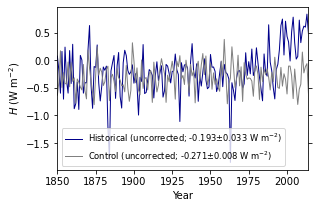

In [25]:
def plot_uncorrected_timeseries(source_member,
                                variable='R',
                                experiments=['piControl', 'historical'],
                                title=None, legend=True, label_mean=True,
                                ax=None):
    """Plot uncorrected time series for variable and experiment(s)."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
    # Loop over experiments (in reverse)
    for exp in experiments[::-1]:
        # Get uncorrected time series data
        uncorr_da = da_dict[(source_member, exp, variable)].copy()
        # For SSPs, show from 2015
        if 'ssp' in exp:  # for SSPs
            uncorr_da = uncorr_da.sel(time=slice(2015,2100))
        # If mean is to be included in label, calculate it (before limiting piControl period)
        if label_mean:
            m = np.mean(uncorr_da.data)  # mean
            sem = stats.sem(uncorr_da.data)  # standard error
            label = f'{exp_dict[exp]} (uncorrected; {m:.3f}$\pm${sem:.3f} {uncorr_da.attrs["units"]})'
        else:
            label = f'{exp_dict[exp]} (uncorrected)'
        # Shift piControl start to 1850 for ease of comparison?
        if (exp == 'piControl') and ('historical' in experiments):
            uncorr_da['time'] = uncorr_da['time'] - uncorr_da['time'][0] + 1850
        # Limit x-axis and time series to 1850-2100 or 1850-2014?
        if bool(set(['ssp126', 'ssp245', 'ssp370', 'ssp585']) & set(experiments)):
            ax.set_xlim([1850, 2100])
            uncorr_da = uncorr_da.sel(time=slice(1850,2100))
        else:
            ax.set_xlim([1850, 2014])
            uncorr_da = uncorr_da.sel(time=slice(1850,2014))
        # Plot time series
        ax.plot(uncorr_da.time, uncorr_da, label=label, color=exp_c_dict[exp], alpha=1.0, linewidth=1.0)
        # Labels, legend etc
        ax.set_xlabel('Year')
        ax.set_ylabel(f'${variable}$ ({uncorr_da.attrs["units"]})')
        ax.tick_params(right=True)
        if title:
            ax.set_title(title)
        if legend:
            ax.legend(fontsize='small')
    return ax

# Example
source_member = source_member_list[-1]
_ = plot_uncorrected_timeseries(source_member, variable='H', experiments=['piControl', 'historical'])

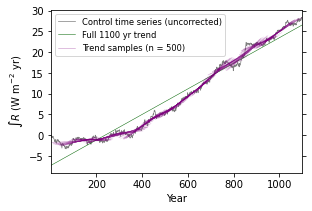

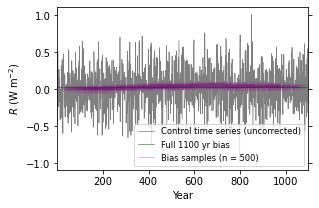

In [26]:
def plot_pi_timeseries_with_trends_means(source_member,
                                         variable='\int R',
                                         plot_trends=True,  # if False, plot means
                                         sample_length=150, sample_n=500,
                                         title=None, legend=True,
                                         ax=None):
    """Plot piControl time series and trends or means."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
    # Input DataArray for piControl time series
    pi_da = da_dict[(source_member, 'piControl', variable)].copy()
    # Plot piControl time series
    ax.plot(pi_da.time, pi_da, label='Control time series (uncorrected)', color='black', alpha=0.5, linewidth=0.7)
    # Plot trend / mean based on full piControl time series, excluding standard error (traditional method)
    if plot_trends:
        full_pi_trend = calc_trend(pi_da, inc_rand_error=False)  # trend slope
        trend_data = np.array([0, float(full_pi_trend*pi_da.time[-1].data)])  # trend line start & end 
        trend_data = trend_data - trend_data.mean() + pi_da.mean().data  # shift to same mean as pi_da
        ax.plot(pi_da.time[[0,-1]], trend_data, color='darkgreen', label=f'Full {len(pi_da)} yr trend',
                linewidth=0.5)
    else:  # plot piConrol mean (ie bias for R and H)
        full_pi_mean = calc_mean(pi_da, inc_rand_error=False)
        ax.plot(pi_da.time[[0,-1]], [full_pi_mean,]*2, color='darkgreen', label=f'Full {len(pi_da)} yr bias',
                linewidth=0.5)
    # Plot trends / means based on random MCDC samples from piControl
    trends_dict, means_dict, start_years = sample_pi_trends_means(source_member,
                                                                  sample_length=sample_length,
                                                                  sample_n=sample_n)
    for i in range(sample_n):  # loop over samples
        b = trends_dict[variable][i]
        m = means_dict[variable][i]
        s = start_years[i]
        x_data = np.array([s, s+sample_length])  # time coverage of this trend/mean estimate
        if plot_trends:  # plot trends
            trend_data = np.array([b*x for x in x_data])  # trend line start & end; shifted to same mean below
            trend_data = trend_data - trend_data.mean() + pi_da.sel(time=slice(x_data[0],x_data[1])).mean().data
            if i == 0:  # add label to legend for only one sample
                label = f'Trend samples (n = {sample_n})'
            else:
                label = None
            ax.plot(x_data, trend_data, color='purple', label=label, alpha=0.3, linewidth=0.2)
        else:  # plot means
            if i == 0:
                label = f'Bias samples (n = {sample_n})'
            else:
                label = None
            ax.plot(x_data, [m,m], color='purple', label=label, alpha=0.3, linewidth=0.2)
    # Labels, legend etc
    ax.set_xlabel('Year')
    ax.set_xlim(pi_da.time[[0,-1]])
    ax.set_ylabel(f'${variable}$ ({pi_da.attrs["units"]})')
    ax.tick_params(right=True)
    if title:
        ax.set_title(title)
    if legend:
        leg = ax.legend(fontsize='small')
        for lh in leg.legendHandles:
            try:  # set min alpha in legend
                if lh.get_alpha() < 0.5:
                    lh.set_alpha(0.5)
            except TypeError:
                pass
            try: # set min linewidth in legend
                if lh.get_linewidth() < 0.5:
                    lh.set_linewidth(0.5)
            except TypeError:
                pass
    return ax

# Example
source_member = source_member_list[-1]
_ = plot_pi_timeseries_with_trends_means(source_member, plot_trends=True)
_ = plot_pi_timeseries_with_trends_means(source_member,
                                         variable='R',
                                         plot_trends=False)

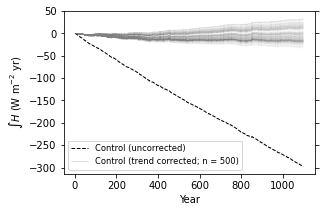

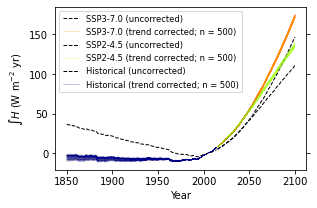

In [27]:
def plot_mc_drift_corr_timeseries(source_member, experiments=['historical', 'ssp126', 'ssp245'],
                                  variable='\int R',
                                  trend_correct=True,  # if False, use integrated-bias correction instead
                                  sample_length=150, sample_n=500,
                                  plot_uncorrected=True,  # also plot uncorrected time series?
                                  ref_1995_2014=False,  # if not rel to 1995-2014, start at zero
                                  title=None, legend=True,
                                  ax=None):
    """Plot drift corrected time series for experiments, using either trend or integrated-bias method."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
    # Loop over experiments (in reverse)
    for exp in experiments[::-1]:
        # Plot original uncorrected time series?
        if plot_uncorrected:
            uncorr_da = da_dict[(source_member, exp, variable)].copy()
            if ref_1995_2014:  # show relative to 1995-2014 mean?
                uncorr_da -= uncorr_da.sel(time=slice(1995,2014)).mean()
            else:  # otherwise, start at zero
                uncorr_da -= uncorr_da[0]
            if 'ssp' in exp:  # for SSPs, show from 2015
                uncorr_da = uncorr_da.sel(time=slice(2015,2100))
            ax.plot(uncorr_da.time, uncorr_da,
                    label=f'{exp_dict[exp]} (uncorrected)',
                    color='k', linestyle='--', linewidth=1)
        # Get data for drift corrected time series
        if trend_correct:  # standard trend method
            corr_da_list = mc_drift_correction(source_member, experiment=exp, variable=variable,
                                               trend_correct=True,
                                               sample_length=sample_length, sample_n=sample_n)
        else:  # integrated-bias method: correct bias of un-integrated variable then integrate cumulatively
            temp_da_list = mc_drift_correction(source_member, experiment=exp, variable=variable[-1],
                                               trend_correct=False,
                                               sample_length=sample_length, sample_n=sample_n)
            corr_da_list = [da.cumsum() for da in temp_da_list]
        # Plot MC drift corrected time series
        for i, corr_da in enumerate(corr_da_list):  # loop over samples
            if i == 0 and trend_correct:  # label only once
                label = f'{exp_dict[exp]} (trend corrected; n = {sample_n})'
            elif i == 0:
                label = f'{exp_dict[exp]} (int.-bias corrected; n = {sample_n})'
            else:
                label = None
            if ref_1995_2014:  # show relative to 1995-2014 mean?
                corr_da -= corr_da.sel(time=slice(1995,2014)).mean()
            else:  # otherwise, start at zero
                corr_da -= corr_da[0]
            if 'ssp' in exp:  # for SSPs, show from 2015
                corr_da = corr_da.sel(time=slice(2015,2100))
            ax.plot(corr_da.time, corr_da, label=label, color=exp_c_dict[exp], alpha=0.1, linewidth=0.15)
    # Labels, legend etc
    ax.set_xlabel('Year')
    y_units = da_dict[(source_member, experiments[0], variable)].copy().attrs["units"]
    if ref_1995_2014 and False:  # always False(!); to include 'rel. to 1995–2014', delete "and False"
        ax.set_ylabel(f'${variable}$ ({y_units}; rel. to 1995–2014)')
    else:
        ax.set_ylabel(f'${variable}$ ({y_units})')
    ax.tick_params(right=True)
    if title:
        ax.set_title(title)
    if legend:
        leg = ax.legend(fontsize='small')
        for lh in leg.legendHandles:
            try:  # set min alpha in legend
                if lh.get_alpha() < 0.5:
                    lh.set_alpha(0.5)
            except TypeError:
                pass
            try: # set min linewidth in legend
                if lh.get_linewidth() < 0.5:
                    lh.set_linewidth(0.5)
            except TypeError:
                pass
    return ax

# Examples
source_member = source_member_list[-1]
for trend_correct in [True,]:
    _ = plot_mc_drift_corr_timeseries(source_member, experiments=['piControl',],
                                      variable='\int H',
                                      trend_correct=trend_correct)
    _ = plot_mc_drift_corr_timeseries(source_member, experiments=['historical', 'ssp245', 'ssp370'],
                                      variable='\int H',
                                      trend_correct=trend_correct,
                                      ref_1995_2014=True)

### Individual plots: lines / scatter showing $\int R - \int H - \Delta Z$ relationships

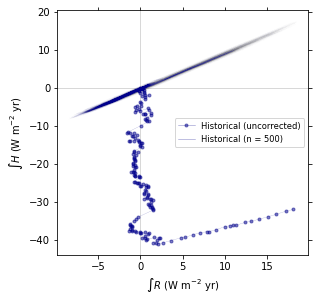

In [28]:
def scatter_line_of_x_y_rel(source_member,
                            x_var='\int R', y_var='\int H',
                            x_trend_correct=True, y_trend_correct=True, # if False, use int.-bias method instead
                            experiments=['historical',],
                            plot_uncorrected=False,  # plot uncorrected time series?
                            sample_length=150, sample_n=500,  # if None, do not plot drift-corrected
                            ref_1995_2014=False,  # if not rel to 1995-2014, start at zero
                            title=None, legend=True,
                            ax=None):
    """Scatter (uncorrected) and/or line (corrected) plot of y_var vs x_var."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
    # Show zero
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
    # Loop over experiments
    for exp in experiments[::-1]:
        # Plot uncorrected data?
        if plot_uncorrected:
            # Get uncorrected data
            x_uncorr_da = da_dict[(source_member, exp, x_var)].copy()
            y_uncorr_da = da_dict[(source_member, exp, y_var)].copy()
            # Prepare uncorrected data
            if ref_1995_2014:  # show relative to 1995-2014 mean?
                x_uncorr_da -= x_uncorr_da.sel(time=slice(1995,2014)).mean()
                y_uncorr_da -= y_uncorr_da.sel(time=slice(1995,2014)).mean()
            else:  # otherwise, start at zero
                x_uncorr_da -= x_uncorr_da[0]
                y_uncorr_da -= y_uncorr_da[0]
            if 'ssp' in exp:  # for SSPs, show from 2015
                x_uncorr_da = x_uncorr_da.sel(time=slice(2015,2100))
                y_uncorr_da = y_uncorr_da.sel(time=slice(2015,2100))
            # Plot uncorrected data
            ax.plot(x_uncorr_da, y_uncorr_da, label=f'{exp_dict[exp]} (uncorrected)',
                    color=exp_c_dict[exp], linestyle='-', linewidth=0.2, marker='.', alpha=0.5)
        # Plot MC drift corrected data?
        if sample_length and sample_n:
            # Get MC drift corrected data for x_var
            if x_trend_correct:  # standard trend method for x_var
                x_corr_da_list = mc_drift_correction(source_member, experiment=exp, variable=x_var,
                                                     trend_correct=True,
                                                     sample_length=sample_length, sample_n=sample_n)
            else: # int.-bias method: correct bias of un-integrated variable then integrate cumulatively
                temp_da_list = mc_drift_correction(source_member, experiment=exp, variable=x_var[-1],
                                                   trend_correct=False,
                                                   sample_length=sample_length, sample_n=sample_n)
                x_corr_da_list = [da.cumsum() for da in temp_da_list]
            # Get MC drift corrected data for y_var
            if y_trend_correct:  # trend method
                y_corr_da_list = mc_drift_correction(source_member, experiment=exp, variable=y_var,
                                                     trend_correct=True,
                                                      sample_length=sample_length, sample_n=sample_n)
            else:  # int.-bias method
                temp_da_list = mc_drift_correction(source_member, experiment=exp, variable=y_var[-1],
                                                   trend_correct=False,
                                                   sample_length=sample_length, sample_n=sample_n)
                y_corr_da_list = [da.cumsum() for da in temp_da_list]
            # Loop over MC drift corrected samples
            for i, x_corr_da, y_corr_da in zip(range(sample_n), x_corr_da_list, y_corr_da_list):
                # Label for plotting
                if i == 0:  # label only once
                    label = f'{exp_dict[exp]} (n = {sample_n})'
                else:
                    label = None
                # Prepare data
                if ref_1995_2014:  # show relative to 1995-2014 mean?
                    x_corr_da -= x_corr_da.sel(time=slice(1995,2014)).mean()
                    y_corr_da -= y_corr_da.sel(time=slice(1995,2014)).mean()
                else:  # otherwise, start at zero
                    x_corr_da -= x_corr_da[0]
                    y_corr_da -= y_corr_da[0]
                if 'ssp' in exp:  # for SSPs, show from 2015
                    x_corr_da = x_corr_da.sel(time=slice(2015,2100))
                    y_corr_da = y_corr_da.sel(time=slice(2015,2100))
                # Plot drift corrected data
                ax.plot(x_corr_da, y_corr_da, label=label,
                        color=exp_c_dict[exp], alpha=0.1, linewidth=0.05)
    # x & y axis labels
    x_units = da_dict[(source_member, experiments[0], x_var)].copy().attrs["units"]
    y_units = da_dict[(source_member, experiments[0], y_var)].copy().attrs["units"]
    if plot_uncorrected:
        xlabel = f'${x_var}$ ({x_units})'
        ylabel = f'${y_var}$ ({y_units})'
    else:
        if x_trend_correct:
            xlabel = f'Trend corrected ${x_var}$ ({x_units})'
        else:
            xlabel = f'Int.-bias corrected ${x_var}$ ({x_units})'
        if y_trend_correct:
            ylabel = f'Trend corrected ${y_var}$ ({y_units})'
        else:
            ylabel = f'Int.-bias corrected ${y_var}$ ({y_units})'
    if ref_1995_2014:
        xlabel = xlabel[:-1] + '; rel. to 1995–2014)'
        ylabel = ylabel[:-1] + '; rel. to 1995–2014)'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Legend, title etc
    ax.tick_params(right=True, top=True)
    if title:
        ax.set_title(title)
    if legend:
        leg = ax.legend(fontsize='small')
        for lh in leg.legendHandles:
            try:  # set min alpha in legend
                if lh.get_alpha() < 0.5:
                    lh.set_alpha(0.5)
            except TypeError:
                pass
            try: # set min linewidth in legend
                if lh.get_linewidth() < 0.5:
                    lh.set_linewidth(0.5)
            except TypeError:
                pass
    return ax

# Example
source_member = source_member_list[-1]
_ = scatter_line_of_x_y_rel(source_member, plot_uncorrected=True)

### Individual plots: histograms of drift

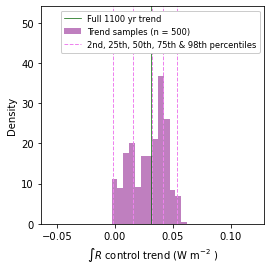

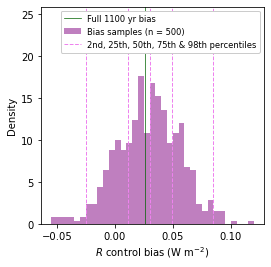

In [29]:
def histogram_of_pi_trends_means(source_member,
                                 variable='\int R', bin_width=0.005,
                                 plot_trends=True,  # if False, plot means
                                 sample_length=150, sample_n=500,
                                 title=None, legend=True,
                                 ax=None,  # Matplotlib Axes object
                                 ):
    """Plot histogram of trends or means for piControl time series."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Full piControl time series trend/mean (as vertical line) 
    pi_da = da_dict[(source_member, 'piControl', variable)].copy()
    if plot_trends:  # trend
        full_pi_trend = calc_trend(pi_da, inc_rand_error=False)
        ax.axvline(x=full_pi_trend, color='darkgreen', label=f'Full {len(pi_da)} yr trend', linewidth=0.7)
    else:  # mean (ie bias for R and H)
        full_pi_mean = calc_mean(pi_da, inc_rand_error=False)
        ax.axvline(x=full_pi_mean, color='darkgreen', label=f'Full {len(pi_da)} yr bias', linewidth=0.7)
    # Random samples from piControl
    trends_dict, means_dict, start_years = sample_pi_trends_means(source_member,
                                                                  sample_length=sample_length,
                                                                  sample_n=sample_n)
    if plot_trends:  # trends
        data = trends_dict[variable]
        label = f'Trend samples (n = {sample_n})'
    else:  # means
        data = means_dict[variable]
        label = f'Bias samples (n = {sample_n})'
    ax.hist(data, bins=np.arange(min(data), max(data)+bin_width, bin_width),
            density=True, color='purple', alpha=0.5,
            label=label)
    # Show 2, 25, 50, 75, 98 percentiles (as vertical lines)
    percentiles = np.percentile(data, [2, 25, 50, 75, 98])
    for i, p in enumerate(percentiles):
        if i == 0:  # label only once in legend
            label = '2nd, 25th, 50th, 75th & 98th percentiles'
        else:
            label = None
        ax.axvline(x=p, color='violet', linestyle='dashed', label=label, linewidth=1)
    # Labels, legend etc
    if plot_trends:
        if pi_da.attrs["units"][-2:] == 'yr':  # yr and yr^-1 cancel
            xlabel = f'${variable}$ control trend ({pi_da.attrs["units"][:-2]})'
        else:
            xlabel = f'${variable}$ control trend ({pi_da.attrs["units"]}'+' yr$^{-1}$)'
    else:
        xlabel = f'${variable}$ control bias ({pi_da.attrs["units"]})'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')  # to include bin width info, swap with commented line below
    #ax.set_ylabel(f'Density (bin width = {bin_width} {pi_da.attrs["units"]})')
    if title:
        ax.set_title(title)
    if legend:
        ax.set_ylim([0, ax.get_ylim()[1]*1.4])  # extend ylim so more room for legend
        ax.legend(fontsize='small', framealpha=1)
    return ax

# Example
source_member = source_member_list[-1]
ax1 = histogram_of_pi_trends_means(source_member,
                                   variable='\int R', bin_width=0.005,
                                   plot_trends=True)
ax2 = histogram_of_pi_trends_means(source_member,
                                   variable='R', bin_width=0.005,
                                   plot_trends=False)
ax1.sharex(ax2)

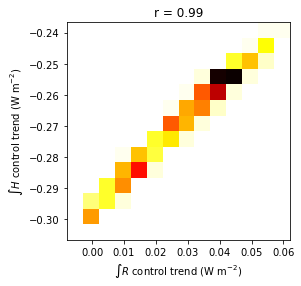

In [30]:
def hist2d_of_pi_trends_means(source_member,
                              x_var='\int R', y_var='\int H',
                              x_plot_trends=True, y_plot_trends=True,  # if False, use means instead
                              x_bin_width=0.005, y_bin_width=0.005,
                              sample_length=150, sample_n=500,
                              title=None,
                              ax=None
                              ):
    """Plot 2-D histogram of trends or means for piControl time series for two variables."""
    # Create figure if ax=None
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Random samples from piControl
    trends_dict, means_dict, start_years = sample_pi_trends_means(source_member,
                                                                  sample_length=sample_length,
                                                                  sample_n=sample_n)
    # x data
    if x_plot_trends:
        x_data = trends_dict[x_var]
    else:
        x_data = means_dict[x_var]
    x_bins = np.arange(min(x_data)-x_bin_width, max(x_data)+x_bin_width, x_bin_width)
    # y data
    if y_plot_trends:
        y_data = trends_dict[y_var]
    else:
        y_data = means_dict[y_var]
    y_bins = np.arange(min(y_data)-y_bin_width, max(y_data)+y_bin_width, y_bin_width)
    # Plot 2D histogram
    ax.hist2d(x_data, y_data, bins=(x_bins, y_bins), density=True, cmap='hot_r')
    # Labels etc
    for x_or_y, plot_trends, var in [('x', x_plot_trends, x_var),
                                     ('y', y_plot_trends, y_var)]:
        units = da_dict[(source_member, 'piControl', var)].copy().attrs['units']
        if plot_trends:
            if units[-3:] == ' yr':  # yr and yr^-1 cancel
                label = f'${var}$ control trend ({units[:-3]})'
            else:
                label = f'${var}$ control trend ({units}'+' yr$^{-1}$)'
        else:
            label = f'${var}$ control bias ({units})'
        if x_or_y == 'x':
            ax.set_xlabel(label)
        else:
            ax.set_ylabel(label)    
    if title:  # include correlation
        ax.set_title(f'{title} (r = {stats.pearsonr(x_data, y_data)[0]:.2f})')
    else:
        ax.set_title(f'r = {stats.pearsonr(x_data, y_data)[0]:.2f}')
    return ax

# Example
source_member = source_member_list[-1]
ax = hist2d_of_pi_trends_means(source_member)

In [31]:
! date

Fri Aug 19 10:59:47 +08 2022
